In [1]:
% matplotlib inline
# % config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
 
#SET UP FIGURE AESTHETICS 
plt.rcParams.update({'axes.labelsize': 20, 'font.size': 20,
                     'legend.fontsize': 18, 'xtick.labelsize': 18,
                     'ytick.labelsize': 18, 'axes.linewidth': 1.5})
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]

#Options
params = {'text.usetex' : True,
          'font.size' : 20,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

import pickle
from scipy.interpolate import interp1d

### used for pooling intensity map
import skimage.measure

from limlam_mocker import limlam_mocker as llm
#Get Parameters for run
from limlam_mocker import params        as params

import lnn as lnn

### load in models
from models_to_load import *

np.random.seed(1337)

%load_ext autoreload

In [2]:
%autoreload
# %autoreload 0
#%autoreload 2

# Setup Enviornment

In [3]:
import tensorflow as tf
from tensorflow import keras

mapLoc = '../maps2/basic_Li/'
different_mapLoc = '../maps2/random_maps2/'
random_small_Li_mapLoc = '../maps2/random_small_Li/'
smaller_mapLoc = '../maps2/random_small_Li_small_map/'
smaller_basic_mapLoc = '../maps2/basic_small_Li_small_map/'

basic_Li_mapLoc = '../maps2/basic_Li/'
random_small_Li_mapLoc = '../maps2/random_small_Li/'
basic_Padmanabhan_mapLoc = '../maps2/basic_Padmanabhan/'
smaller_random_small_Li_mapLoc = '../maps2/random_small_Li_small_map/'
smaller_basic_Li_mapLoc = '../maps2/basic_small_Li_small_map/'
smaller_basic_Padmanabhan_mapLoc = '../maps2/basic_Padmanabhan_small_map/'

catLoc = '../catalogues2/'

modelLoc = '../fix_paper_models/'

dataLoc = '../data/'
valPredictionLoc = dataLoc + 'predictions/fix_paper/'

### map info
numb_maps = 100
pix_x = 256
pix_y = 256

### output info
lum_func_size = 49
less_lums = 35

# Load Maps

In [4]:
# function to load map names after randomizing them based on a given seed
def load_map_paths(mapLoc, seed=1234):
    # load file names
    subFields = lnn.loadBaseFNames(mapLoc)
    # 'randomize'
    np.random.seed(1234)
    np.random.shuffle(subFields)
    np.random.seed()

    # get the path to the maps
    base = [mapLoc + s for s in subFields]
    
    # return the paths
    return(base)

In [5]:
basic_Li_base = load_map_paths(basic_Li_mapLoc)
random_small_Li_base = load_map_paths(random_small_Li_mapLoc)
basic_Padmanabhan_base = load_map_paths(basic_Padmanabhan_mapLoc)

smaller_random_small_Li_base = load_map_paths(smaller_random_small_Li_mapLoc)
smaller_basic_Li_base = load_map_paths(smaller_basic_Li_mapLoc)
smaller_basic_Padmanabhan_base = load_map_paths(smaller_basic_Padmanabhan_mapLoc)

lumLogBinCents = lnn.loadData(basic_Li_base[152] + '_lum.npz')['logBinCent']

# Load Power Spectrum Results

In [6]:
def load_power_data(file_name):
    data = np.loadtxt(file_name, delimiter=',')
    lum = sorted(data[:,0])
    phi = list(sorted(data[:,1], reverse=True))
    return(lum, phi)

def interpolate_power_data(lum, phi, min_val, max_val):
    f = interp1d(lum, phi)
    
    new_lum = np.logspace(min_val,max_val,50)
    new_phi = f(new_lum)
    
    return(new_lum, new_phi)

In [7]:
# Load Harvard's data (this was screen scraped)
file_upper = 'comap_power_data/upper_limit.txt'
file_lower = 'comap_power_data/lower_limit.txt'
file_simulated = 'comap_power_data/underlying.txt'

# Data is storaed individually for the best fit line, lower 95% interval and upper 95% interval
upper_lum, upper_phi = lnn.load_power_data(file_upper)
lower_lum, lower_phi = lnn.load_power_data(file_lower)
simulated_lum, simulated_phi = lnn.load_power_data(file_simulated)

# get min and max log value to generate luminosities to get everything based on the same luminosities
min_val = np.log10(max([upper_lum[0], lower_lum[0], simulated_lum[0]]))
max_val = np.log10(min([upper_lum[-1], lower_lum[-1], simulated_lum[-1]]))

# interpolate the data to get everything on the same set of underlying luminosities
upper_lum, upper_phi = lnn.interpolate_power_data(upper_lum, upper_phi, min_val, max_val)
lower_lum, lower_phi = lnn.interpolate_power_data(lower_lum, lower_phi, min_val, max_val)
simulated_lum, simulated_phi = lnn.interpolate_power_data(simulated_lum, simulated_phi, min_val, max_val)

# Harvard's data is 
conversion_to_make_Harvards_data_match_mine = 10**6.3342749483296803
upper_phi = upper_phi * conversion_to_make_Harvards_data_match_mine
lower_phi = lower_phi * conversion_to_make_Harvards_data_match_mine
simulated_phi = simulated_phi * conversion_to_make_Harvards_data_match_mine

upper_err = (upper_phi - simulated_phi)/2
lower_err = (simulated_phi - lower_phi)/2

log_upper_err = upper_err / simulated_phi / np.log(10)
log_lower_err = lower_err / simulated_phi / np.log(10)
log_simulated_phi = np.log10(simulated_phi)

upper_ratio_log = log_upper_err/log_simulated_phi
lower_ratio_log = log_lower_err/log_simulated_phi
ratio = log_simulated_phi/log_simulated_phi

# Actual Plots

## Residual Plots

In [8]:
# function to get label from tests
def label_from_tests(test, file_name_prefix=''):
    label = ''
    
    if test == 'basic':
        label = 'No Noise + Random Li'
    if test == 'noisy':
        label = 'Fiducial Noise + Random Li'
    if test == 'noisy_foreground_random':
        label = 'Random Noise/Foregrounds + Random Li'
        
    if test == 'basic_basic_Li':
        label = 'No Noise + Fiducial Li'
    if test == 'noisy_basic_Li':
        label = 'Fiducial Noise + Fiducial Li'
    if test == 'noisy_foreground_random_basic_Li':
        label = 'Random Noise/Foregrounds + Fiducial Li'
        
    if test == 'less_high_sources':
        label = 'Random Noise/Foregrounds + Less Bright Sources + Random Li'
    if test == 'geometric_noise':
        label = 'Random Noise/Foregrounds + Geometric Noise + Random Li'
    if test == 'basic_Padmanabhan':
        label = 'Random Noise/Foregrounds + Fiducial Padmanabhan'
    
    if file_name_prefix != '':
        label = label + ': ' + file_name_prefix
    
    return(label)

# function to load all of the residual predicitons for a given model
def full_load_predictions(valPredictionLoc, file_name_prefix, tests, prefix_in_label=False):
    predictions = {}
    
    for test in tests:
        if prefix_in_label:
    #         print(valPredictionLoc + file_name_prefix + '_' + test)
            label = label_from_tests(test, file_name_prefix)
        else:
            label = label_from_tests(test)
#         print('Loading ' + label)
        
        try:
            residual_pickle = lnn.load_pickle(valPredictionLoc + file_name_prefix + '_' + test)
        except:
            print("You don't have tests for {0}".format(test))
        else:
            try:
                predictions[test] = lnn.Prediction(residual_pickle, label)
            except:
                print("Something went wrong with analyzing the {0} data".format(test))
        
    return(predictions)

def res_plot_from_single_model(res_list, lumLogBinCents, single_res=None, colors=None, conf=0):
    if colors == None:
        colors = ['tab:blue', 'tab:orange', 'tab:green']

    ax = lnn.plot_res_contour_full(res_list, lumLogBinCents, lum_points=True, colors=colors, plot_range=[-1.1, 5], conf=conf)
    
    if single_res != None:
        color = 'tab:red'
        lnn.plot_res_contour(ax, single_res, lumLogBinCents, alpha=0.25, color=color,
                    label='Fiducial Noise + Fiducial Li', conf=conf)
    
        handles, labels = ax.get_legend_handles_labels()
        ordering = [2,1,0,4,3]
    else:
        handles, labels = ax.get_legend_handles_labels()
        ordering = [2,1,0,3]
    
    handles = [handles[i] for i in ordering]
    labels = [labels[i] for i in ordering]
    ax.legend(handles, labels, loc='upper left')

    plt.xlabel('$L$ (L$_{\odot}$)')
    plt.ylabel(r'$\delta L \Phi$')
    
    return(ax)

def all_res_plots_from_single_model(model_predictions, lumLogBinCents, conf=0):
    res_list = [model_predictions['basic_basic_Li'], model_predictions['noisy_basic_Li'], model_predictions['noisy_foreground_random_basic_Li']]
    res_list.reverse()
    colors = ['tab:blue', 'tab:red', 'tab:orange']
    ax1 = res_plot_from_single_model(res_list, lumLogBinCents, single_res=None, colors=colors, conf=conf)
    
    res_list = [model_predictions['basic'], model_predictions['noisy'], model_predictions['noisy_foreground_random']]
    res_list.reverse()
    single_res = model_predictions['noisy_basic_Li']
    ax2 = res_plot_from_single_model(res_list, lumLogBinCents, single_res=single_res, conf=conf)
    
    if 'basic_Padmanabhan' in model_predictions:
        res_list = [model_predictions['less_high_sources'], model_predictions['geometric_noise'], model_predictions['basic_Padmanabhan']]
        res_list.reverse()
        single_res = model_predictions['noisy_basic_Li']
        ax3 = res_plot_from_single_model(res_list, lumLogBinCents, single_res=single_res, conf=conf)
    else:
        ax3 = None
    
    return(ax1, ax2, ax3)
    
    

In [9]:
%autoreload

In [10]:
tests = ['basic', 'noisy', 'noisy_foreground_random', 'basic_basic_Li', 'noisy_basic_Li', 
         'noisy_foreground_random_basic_Li', 'less_high_sources', 'geometric_noise', 'basic_Padmanabhan']

In [11]:
nnnmlf_pred = full_load_predictions(valPredictionLoc, 'nnnmlf', tests)

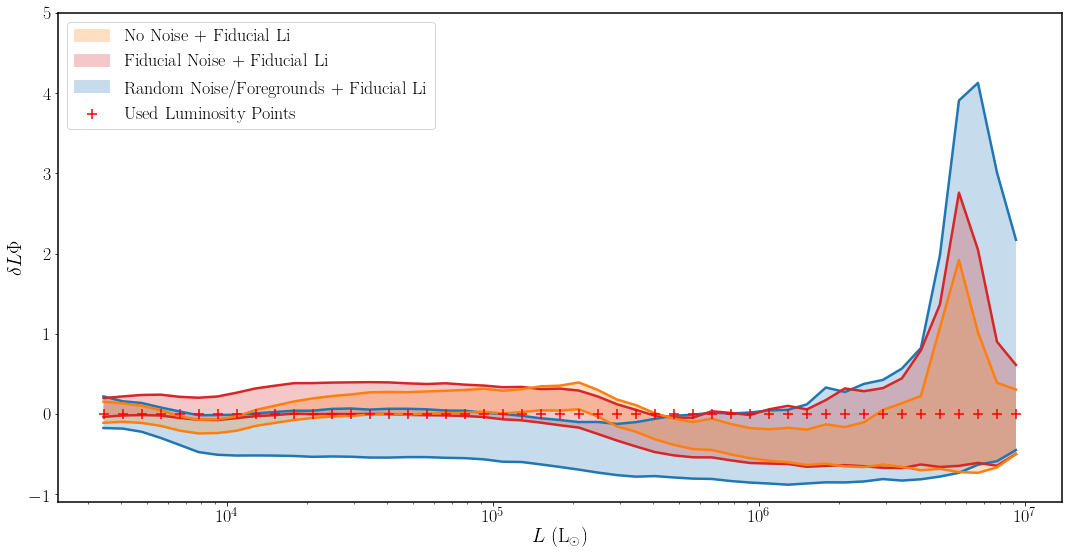

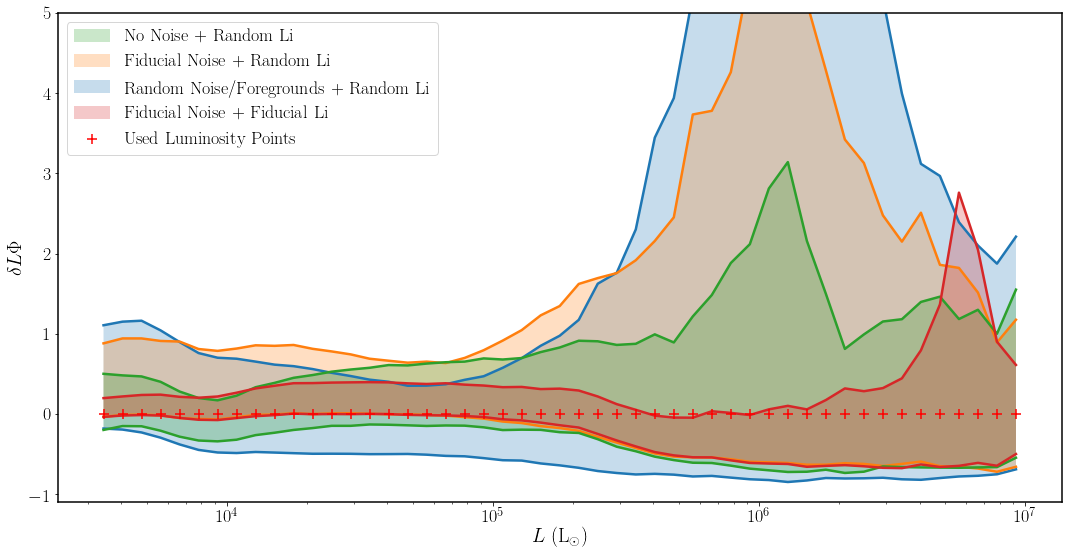

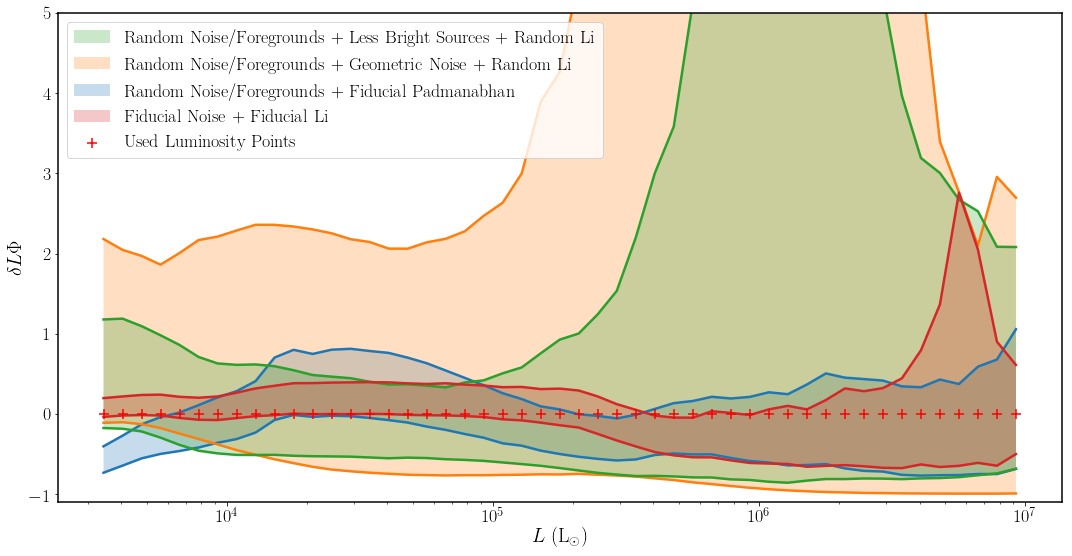

In [13]:
ax1,ax2,ax3 = all_res_plots_from_single_model(nnnmlf_pred, lumLogBinCents)

plt.show(ax1)
ax1.figure.savefig('../figures/basic_Li_comparison.pdf', bbox_inches='tight')

plt.show(ax2)
ax2.figure.savefig('../figures/small_Li_comparison.pdf', bbox_inches='tight')

plt.show(ax3)
ax3.figure.savefig('../figures/random_comparison.pdf', bbox_inches='tight')

In [12]:
res_list2 = [nnnmlf_pred['noisy_basic_Li']]
res_list2.reverse()

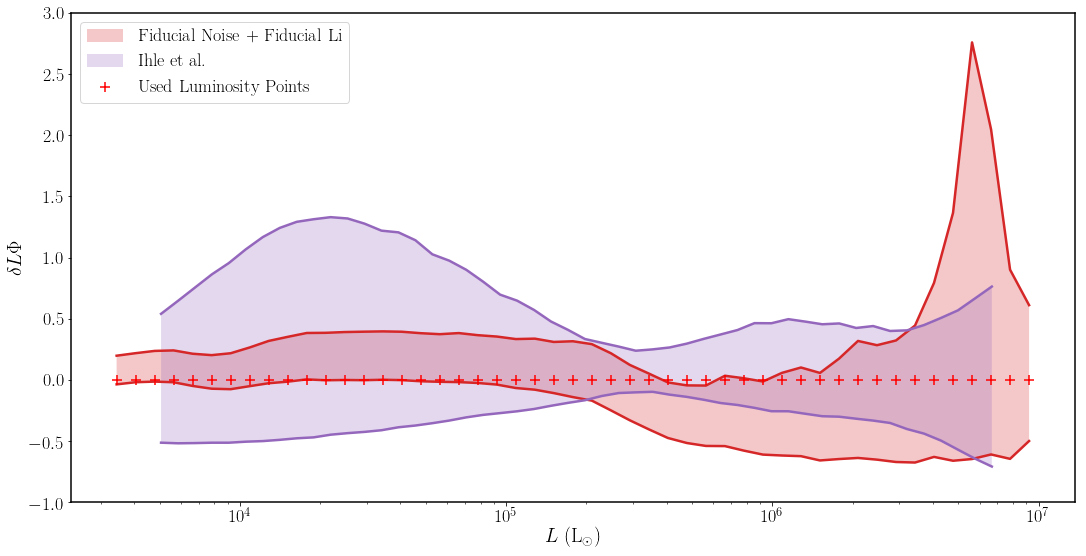

In [13]:
colors = ['tab:red']
ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, plot_range=[-1, 3])#plot_range=[-1, 10])

color = 'tab:purple'
ax = lnn.plot_outside_contour(ax, [-2*lower_err/simulated_phi, 2*upper_err/simulated_phi], simulated_lum, 
                          'Ihle et al.', alpha=0.25, color=color)

handles, labels = ax.get_legend_handles_labels()
ordering = [0,2,1]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left')

plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
# plt.show(ax)
plt.savefig('../figures/Ihle_comparison.pdf', bbox_inches='tight')

In [14]:
lums = lnn.loadLums(basic_Li_base[-836]+'_lum.npz', 'basic') #-836

f = interp1d(lumLogBinCents, lums)
lum_to_ihle = f(simulated_lum)

conversion_to_make_Harvards_data_match_mine = 10**6.3342749483296803
conv = conversion_to_make_Harvards_data_match_mine

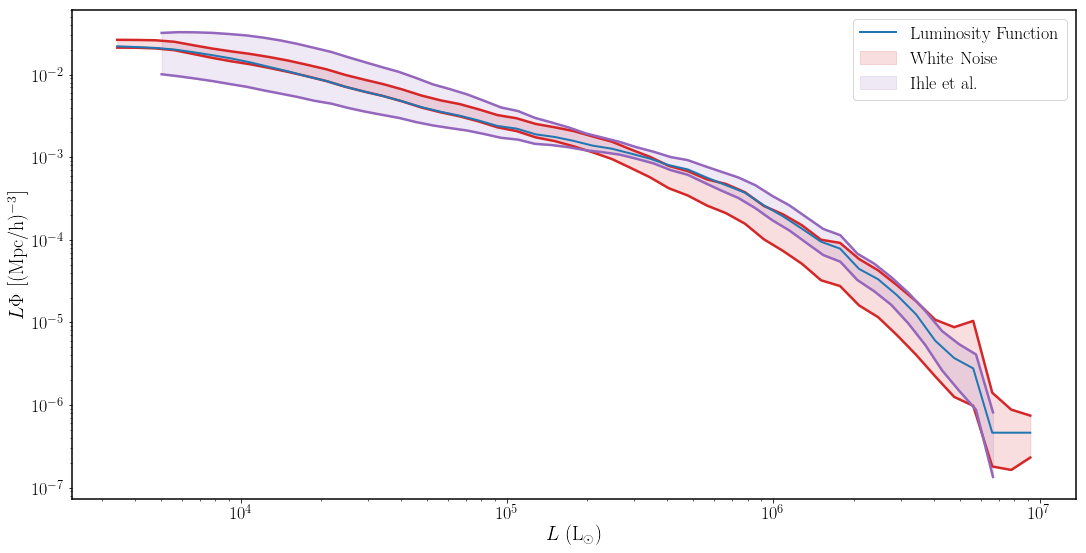

In [15]:
fig, ax = plt.subplots(figsize=(18, 9))

color = 'tab:red'
p = ax.fill_between(lumLogBinCents, lums*(1+nnnmlf_pred['noisy_basic_Li'].transformed_res_conf_interval[:,0])/conv, 
                 lums*(1+nnnmlf_pred['noisy_basic_Li'].transformed_res_conf_interval[:,1])/conv, 
                 alpha=0.15, label='White Noise', color=color)
color = p.get_facecolor()
ax.plot(lumLogBinCents[:nnnmlf_pred['noisy_basic_Li'].lum_func_size], 
        lums*(1+nnnmlf_pred['noisy_basic_Li'].transformed_res_conf_interval[:,0])/conv, 
        color=color[0][:-1], linewidth=2.5)
ax.plot(lumLogBinCents[:nnnmlf_pred['noisy_basic_Li'].lum_func_size], 
        lums*(1+nnnmlf_pred['noisy_basic_Li'].transformed_res_conf_interval[:,1])/conv, 
        color=color[0][:-1], linewidth=2.5)

color = 'tab:purple'
p = ax.fill_between(simulated_lum, lum_to_ihle*(1-2*lower_err/simulated_phi)/conv, 
                    lum_to_ihle*(1+2*upper_err/simulated_phi)/conv, 
                 alpha=0.15, label='Ihle et al.', color=color)
color = p.get_facecolor()
ax.plot(simulated_lum, lum_to_ihle*(1-2*lower_err/simulated_phi)/conv, color=color[0][:-1], linewidth=2.5)
ax.plot(simulated_lum, lum_to_ihle*(1+2*upper_err/simulated_phi)/conv, color=color[0][:-1], linewidth=2.5)

ax.plot(lumLogBinCents, lums/conv, label='Luminosity Function', linewidth=2)

plt.xscale('log')
plt.yscale('log')
# plt.ylim([-0.75,0.75])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^{-3}$]')
plt.legend()

# plt.show(ax)
plt.savefig('../figures/Ihle_comparison_raw.pdf', bbox_inches='tight')

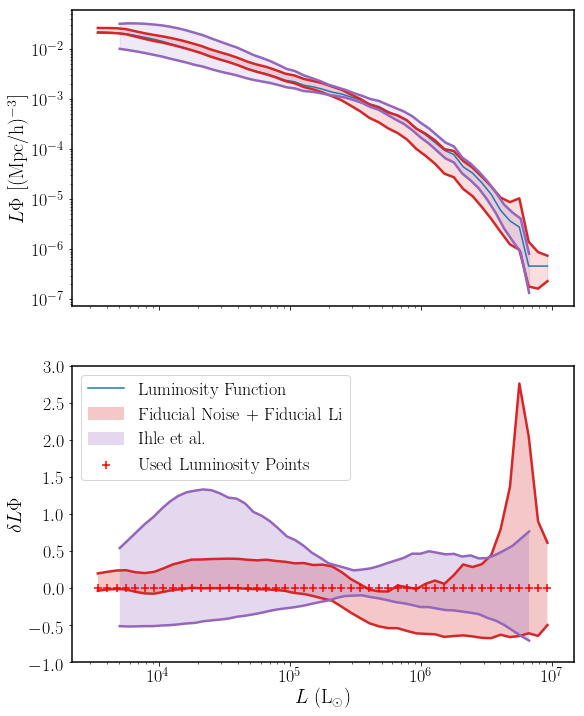

In [16]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 12))

ax[0].plot(lumLogBinCents, lums/conv, label='Luminosity Function')

color = 'tab:red'
p = ax[0].fill_between(lumLogBinCents, lums*(1+nnnmlf_pred['noisy_basic_Li'].transformed_res_conf_interval[:,0])/conv, 
                 lums*(1+nnnmlf_pred['noisy_basic_Li'].transformed_res_conf_interval[:,1])/conv, 
                 alpha=0.15, label='White Noise', color=color)
color = p.get_facecolor()
ax[0].plot(lumLogBinCents[:nnnmlf_pred['noisy_basic_Li'].lum_func_size], 
        lums*(1+nnnmlf_pred['noisy_basic_Li'].transformed_res_conf_interval[:,0])/conv, 
        color=color[0][:-1], linewidth=2.5)
ax[0].plot(lumLogBinCents[:nnnmlf_pred['noisy_basic_Li'].lum_func_size], 
        lums*(1+nnnmlf_pred['noisy_basic_Li'].transformed_res_conf_interval[:,1])/conv, 
        color=color[0][:-1], linewidth=2.5)

color = 'tab:purple'
p = ax[0].fill_between(simulated_lum, lum_to_ihle*(1-2*lower_err/simulated_phi)/conv, 
                       lum_to_ihle*(1+2*upper_err/simulated_phi)/conv, 
                 alpha=0.15, label='Ihle et al.', color=color)
color = p.get_facecolor()
ax[0].plot(simulated_lum, lum_to_ihle*(1-2*lower_err/simulated_phi)/conv, color=color[0][:-1], linewidth=2.5)
ax[0].plot(simulated_lum, lum_to_ihle*(1+2*upper_err/simulated_phi)/conv, color=color[0][:-1], linewidth=2.5)

ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_ylabel('$L \Phi$ [(Mpc/h)$^{-3}$]')


colors = ['tab:red']
ax[1] = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, plot_range=[-1, 3], 
                                  ax=ax[1], lum_point_size=50)

color = 'tab:purple'
ax[1] = lnn.plot_outside_contour(ax[1], [-2*lower_err/simulated_phi, 2*upper_err/simulated_phi], simulated_lum, 
                          'Ihle et al.', alpha=0.25, color=color)

handles_top, labels_top= ax[0].get_legend_handles_labels()

handles_bottom, labels_bottom = ax[1].get_legend_handles_labels()
ordering_bottom = [0,2,1]
handles_bottom = [handles_top[0]] + [handles_bottom[i] for i in ordering_bottom]
labels_bottom = [labels_top[0]] + [labels_bottom[i] for i in ordering_bottom]
ax[1].legend(handles_bottom, labels_bottom, loc='upper left')

ax[1].set_ylabel(r'$\delta L \Phi$')
ax[1].set_xlabel(r'$L$ (L$_{\odot}$)')

# plt.show()
plt.savefig('../figures/Ihle_comparison_full.pdf', bbox_inches='tight')

In [141]:
# res_list2 = [basic_Padmanabhan_pred, less_high_sources_pred, nfr_noisy_foreground_random_resnet_pred]
res_list2 = [nnnmlf_pred['noisy_foreground_random'], nnnmlf_pred['less_high_sources']]
res_list2.reverse()

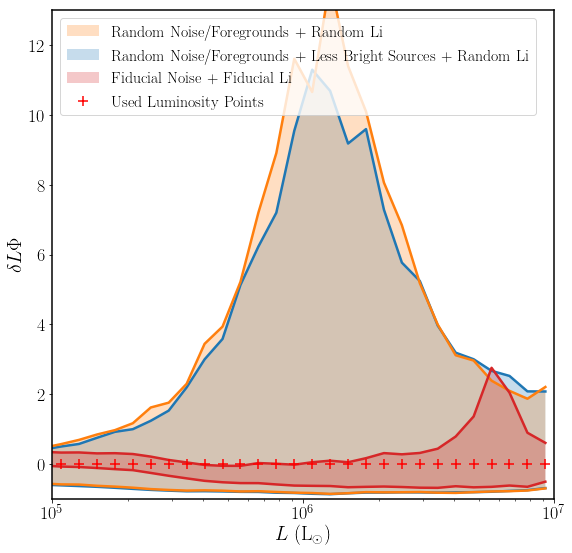

In [142]:
# colors = ['tab:blue', 'tab:orange', 'tab:green']
colors = ['tab:blue', 'tab:orange']

ax = lnn.plot_res_contour_full(res_list2, lumLogBinCents, lum_points=True, colors=colors, 
                           figsize=(9,9), plot_range=[-1, 13])#plot_range=[-1, 25])

color = 'tab:red'
lnn.plot_res_contour(ax, nnnmlf_pred['noisy_basic_Li'], lumLogBinCents, alpha=0.25, color=color,
                 label='Fiducial Noise + Fiducial Li')

handles, labels = ax.get_legend_handles_labels()
ordering = [1,0,3,2]
handles = [handles[i] for i in ordering]
labels = [labels[i] for i in ordering]
ax.legend(handles, labels, loc='upper left', fontsize=16)

ax.set_xlim([10**5, 10**7])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel(r'$\delta L \Phi$')
# plt.show(ax)
plt.savefig('../figures/large_comparison.pdf', bbox_inches='tight')

# Histories

In [143]:
def history_wrapper(name, loc):
    history = lnn.get_full_history(name, loc)
    ax = lnn.plot_single_history(history, second_color='turquoise')

    ax.yaxis.set_tick_params(width=2, size=5)
    for line in ax.yaxis.get_minorticklines():
        line.set_markersize(3)
        line.set_markeredgewidth(2)

    lims = ax.get_ylim()
    ax.set_ylim(lims[0], 1)
    # ax.set_xlim(0, 200)
    
    return(ax)

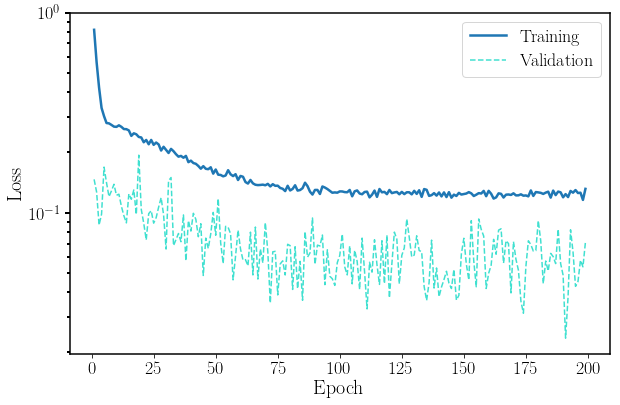

In [144]:
ax = history_wrapper('new_network_new_maps_less_foregrounds', modelLoc)
# plt.show(ax)
plt.savefig('../figures/training_history.pdf', bbox_inches='tight')

# Training Data

In [17]:
# random_small_Li_mapLoc = '../maps2/random_small_Li/'

# subFields = lnn.loadBaseFNames(random_small_Li_mapLoc)
# small_base = [random_small_Li_mapLoc + s for s in subFields]
lums = lnn.load_lums(smaller_random_small_Li_base, lumLogBinCents)

means = np.zeros(len(lums[0]))
lower = np.zeros(len(lums[0]))
upper = np.zeros(len(lums[0]))

for i, val in enumerate(lums[0]):
    means[i] = np.mean(lums[:,i])
    ls = sorted(lums[:,i])[145:-145]
    
    lower[i] = (means[i] - ls[0]) / 2
    upper[i] = (ls[-1] - means[i]) / 2

In [18]:
lums = lnn.load_lums(smaller_basic_Li_base, lumLogBinCents)

means_fid = np.zeros(len(lums[0]))

for i, val in enumerate(lums[0]):
    means_fid[i] = np.mean(lums[:,i])

In [19]:
conversion_to_make_Harvards_data_match_mine = 10**6.3342749483296803
conv = conversion_to_make_Harvards_data_match_mine

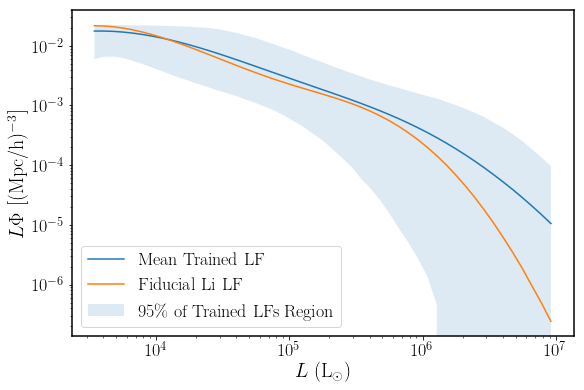

In [20]:
fig, ax = plt.subplots(figsize=(9, 6))

plt.fill_between(lumLogBinCents, (means-2*lower)/conv, (means+2*upper)/conv, alpha=0.15, label='95\% of Trained LFs Region')
plt.plot(lumLogBinCents, means/conv, label='Mean Trained LF')
plt.plot(lumLogBinCents, means_fid/conv, label='Fiducial Li LF')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([-0.75,0.75])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^{-3}$]')
# plt.title('Intrinsic Scatter of Simulated IMs')
plt.legend()

# plt.show(ax)
plt.savefig('../figures/training_lum_funcs.pdf', bbox_inches='tight')

## Network Test

In [21]:
conversion_to_make_Harvards_data_match_mine = 10**6.3342749483296803
conv = conversion_to_make_Harvards_data_match_mine

In [22]:
%autoreload

In [23]:
nnnmlf = get_master_res_next_small(modelLoc, 64, 64, 10, lum_func_size,
                extra_file_name='', file_name='new_network_new_maps_less_foregrounds',
                dense_layer=1000, base_filters=64, cardinality=1,
                give_weights=True, use_bias=True)

In [24]:
nnnmlf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 10, 1 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 32, 5, 64 22016       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 5, 64 256         conv3d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 5, 64 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
max_poolin

In [33]:
# Uses the last 20% of data as validation so it wants the value from the back of the array

# numb = np.random.choice(range(len(random_small_Li_base[-1000:])), 1)[0]
numb = 2

noise = np.random.uniform(0, 7.98)
print('noise: {0}'.format(noise))
print('base number: {0}'.format(numb))
print(random_small_Li_base[-numb], '\n----------------------------')

cur_lum_good, cnn_lum_good, loss = lnn.test_model(nnnmlf, smaller_random_small_Li_base, -numb, 'log', True, pre_pool=1, 
                                      log_input=True, pre_pool_z=1, lum_func_size=lum_func_size,
                                       make_map_noisy=noise, add_foregrounds=True,
                                       random_foreground_params=True, gaussian_smoothing=3,
                                                 pix_x=64, pix_y=64)

noise: 4.616334185263752
base number: 2
../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13599_rotate_0_subfield_3__Li_-1.120e-02_1.377e+00_-1.217e+00_3.175e-01_3.047e-01 
----------------------------
Error and MSE for the given base_number:
[0.012513668276369572, 0.025428395718336105]


In [27]:
# Uses the last 20% of data as validation so it wants the value from the back of the array

# numb = np.random.choice(range(len(random_small_Li_base[-1000:])), 1)[0]
numb = 19

noise = np.random.uniform(0, 7.98)
noise = 7
print('noise: {0}'.format(noise))
print('base number: {0}'.format(numb))
print(random_small_Li_base[-numb], '\n----------------------------')

cur_lum_eh, cnn_lum_eh, loss = lnn.test_model(nnnmlf, smaller_random_small_Li_base, -numb, 'log', True, pre_pool=1, 
                                      log_input=True, pre_pool_z=1, lum_func_size=lum_func_size,
                                       make_map_noisy=noise, add_foregrounds=True,
                                       random_foreground_params=True, gaussian_smoothing=3,
                                                 pix_x=64, pix_y=64)

noise: 7
base number: 19
../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13773_rotate_0_subfield_11__Li_-3.913e-02_1.308e+00_-1.773e+00_2.885e-01_2.916e-01 
----------------------------
Error and MSE for the given base_number:
[0.0053820526227355003, 0.010841072537004948]


In [28]:
# Uses the last 20% of data as validation so it wants the value from the back of the array

# numb = np.random.choice(range(len(random_small_Li_base[-1000:])), 1)[0]
numb = 415

noise = np.random.uniform(0, 7.98)
print('noise: {0}'.format(noise))
print('base number: {0}'.format(numb))
print(random_small_Li_base[-numb], '\n----------------------------')

cur_lum_bad, cnn_lum_bad, loss = lnn.test_model(nnnmlf, smaller_random_small_Li_base, -numb, 'log', True, pre_pool=1, 
                                      log_input=True, pre_pool_z=1, lum_func_size=lum_func_size,
                                       make_map_noisy=noise, add_foregrounds=True,
                                       random_foreground_params=True, gaussian_smoothing=3,
                                                 pix_x=64, pix_y=64)

noise: 2.0710510683714576
base number: 415
../maps2/random_small_Li/COMAP_z2.39-3.44_1140Mpc_seed_13671_rotate_0_subfield_26__Li_-3.487e-02_1.335e+00_-1.126e+00_2.961e-01_2.981e-01 
----------------------------
Error and MSE for the given base_number:
[0.069522328674793243, 0.14869087934494019]


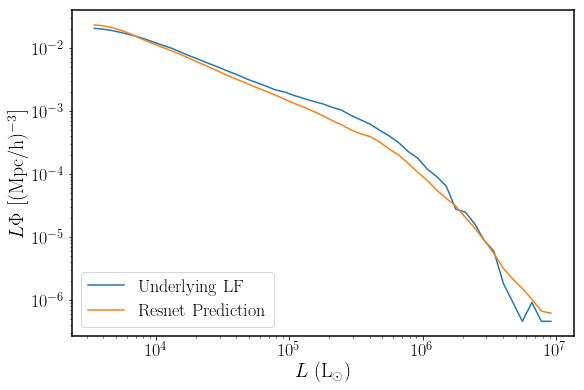

In [34]:
fig, ax = plt.subplots(figsize=(9, 6))

true_lum = 10**cur_lum_good
cnn_guess = 10**cnn_lum_good[0]

plt.plot(lumLogBinCents, true_lum/conv, label='Underlying LF')
plt.plot(lumLogBinCents, cnn_guess/conv, label='Resnet Prediction')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([1,10**5.5])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^{-3}$]')
# # plt.title('Intrinsic Scatter of Simulated IMs')
plt.legend(loc='lower left')

# plt.show(ax)
plt.savefig('../figures/guess_range_good.pdf', bbox_inches='tight')

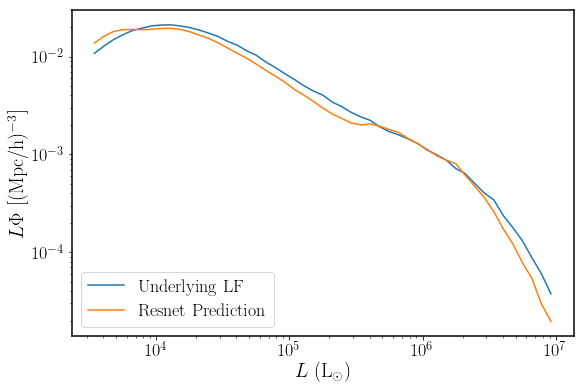

In [30]:
fig, ax = plt.subplots(figsize=(9, 6))

true_lum = 10**cur_lum_eh
cnn_guess = 10**cnn_lum_eh[0]

plt.plot(lumLogBinCents, true_lum/conv, label='Underlying LF')
plt.plot(lumLogBinCents, cnn_guess/conv, label='Resnet Prediction')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([1,10**5.5])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^{-3}$]')
# # plt.title('Intrinsic Scatter of Simulated IMs')
plt.legend(loc='lower left')

# plt.show(ax)
plt.savefig('../figures/guess_range_eh.pdf', bbox_inches='tight')

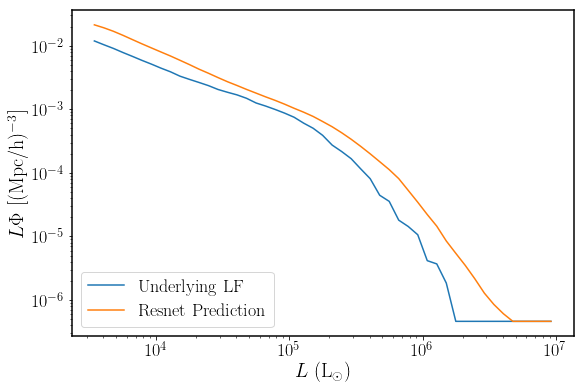

In [31]:
fig, ax = plt.subplots(figsize=(9, 6))

true_lum = 10**cur_lum_bad
cnn_guess = 10**cnn_lum_bad[0]

plt.plot(lumLogBinCents, true_lum/conv, label='Underlying LF')
plt.plot(lumLogBinCents, cnn_guess/conv, label='Resnet Prediction')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([1,10**5.5])
plt.xlabel('$L$ (L$_{\odot}$)')
plt.ylabel('$L \Phi$ [(Mpc/h)$^{-3}$]')
# # plt.title('Intrinsic Scatter of Simulated IMs')
plt.legend(loc='lower left')

# plt.show(ax)
plt.savefig('../figures/guess_range_bad.pdf', bbox_inches='tight')

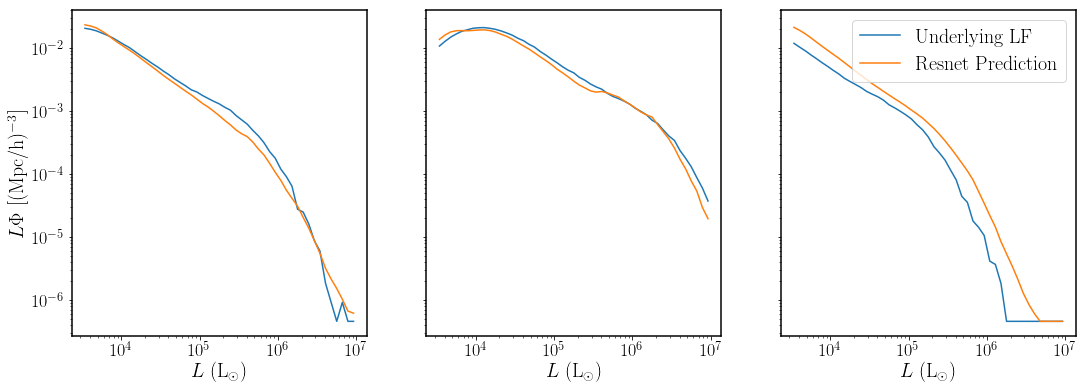

In [35]:
fig, ax = plt.subplots(1, 3, sharey='row', figsize=(18, 6))

true_lum_good = 10**cur_lum_good
cnn_guess_good = 10**cnn_lum_good[0]

true_lum_eh = 10**cur_lum_eh
cnn_guess_eh = 10**cnn_lum_eh[0]

true_lum_bad = 10**cur_lum_bad
cnn_guess_bad = 10**cnn_lum_bad[0]

ax[0].loglog(lumLogBinCents, true_lum_good/conv, label='Underlying LF')
ax[0].loglog(lumLogBinCents, cnn_guess_good/conv, label='Resnet Prediction')

ax[1].loglog(lumLogBinCents, true_lum_eh/conv, label='Underlying LF')
ax[1].loglog(lumLogBinCents, cnn_guess_eh/conv, label='Resnet Prediction')

ax[2].loglog(lumLogBinCents, true_lum_bad/conv, label='Underlying LF')
ax[2].loglog(lumLogBinCents, cnn_guess_bad/conv, label='Resnet Prediction')

ax[0].set_xlabel('$L$ (L$_{\odot}$)')
ax[0].set_ylabel('$L \Phi$ [(Mpc/h)$^{-3}$]')

ax[1].set_xlabel('$L$ (L$_{\odot}$)')
# ax[1].legend(loc='upper right')

ax[2].set_xlabel('$L$ (L$_{\odot}$)')
ax[2].legend(loc='upper right', prop={'size': 20})

# plt.show()
plt.savefig('../figures/guess_range.pdf', bbox_inches='tight')

## IM Slices

In [9]:
data = np.load(smaller_basic_Li_base[750] + '_map.npz')
# data = np.load(random_small_Li_base[745] + '_map.npz')
basic_map = data['map_cube']

In [10]:
intensities = basic_map.ravel()
intensities_non_zero = intensities[intensities != 0]
bins = np.arange(0, .2, .01)

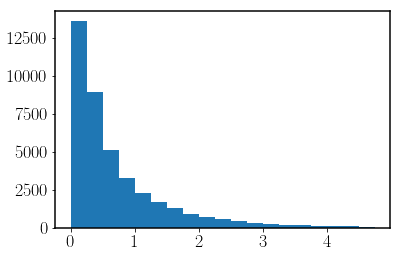

In [15]:
maxx = 5
bins = np.arange(0, maxx, maxx/20)
plt.hist(intensities_non_zero, bins=bins)
plt.show()

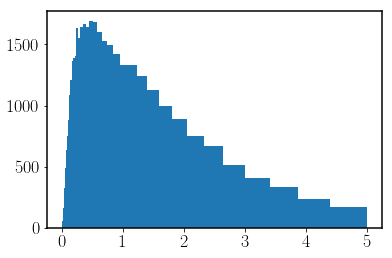

In [16]:
log_bins = np.logspace(-2, np.log10(5))
plt.hist(intensities_non_zero, bins=log_bins)
plt.show()

In [19]:
noise = np.random.normal(0, 4.39, (64,44))

from scipy.ndimage import gaussian_filter

fwhm = 2.355
gaussian_smoothing_sigma = 4
sigma = (gaussian_smoothing_sigma/fwhm,gaussian_smoothing_sigma/fwhm)

result = gaussian_filter(noise, sigma=sigma)

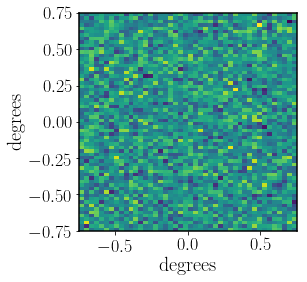

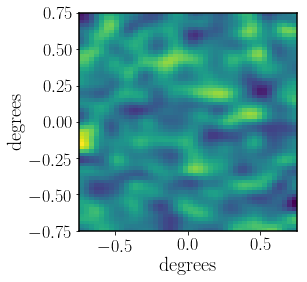

In [20]:
im = plt.imshow(noise,
                extent=[-1.5/2,1.5/2,-1.5/2,1.5/2])#,
                #vmin=-1,vmax=2)
plt.xlabel('degrees')
plt.ylabel('degrees')
plt.show()

im = plt.imshow(result,
                extent=[-1.5/2,1.5/2,-1.5/2,1.5/2])#,
                #vmin=-1,vmax=2)
plt.xlabel('degrees')
plt.ylabel('degrees')
plt.show()

In [153]:
%autoreload

In [154]:
data = np.load(smaller_basic_Li_base[750] + '_map.npz')

basic_map = data['map_cube']
log_mod_basic_map = lnn.log_modulus(basic_map)

noisy_map = np.random.normal(0, 4.389, basic_map.shape)

model_params_obj = lnn.ModelParams()
model_params_obj.give_attributes(pre_pool=1, pre_pool_z=1, pix_x=64, pix_y=64)
model_params_obj.clean_parser_data()
model_params_obj.get_map_info(smaller_basic_Li_base[745] + '_map.npz')
foreground_map = lnn.makeFGcube(int(model_params_obj.pix_x), int(model_params_obj.pix_y), 
                                model_params_obj.omega_pix, model_params_obj.nu, 
                                random_foreground_params=False)

geometric_noise_map = lnn.make_geometric_noise_map(basic_map.shape, 1.0/22, 100)

combined_map = basic_map + noisy_map + foreground_map

In [155]:
basic_pool_map_smoothed = lnn.apply_gaussian_smoothing(basic_map, 3)
noisy_pool_map_smoothed = lnn.apply_gaussian_smoothing(noisy_map, 3)
foreground_pool_map_smoothed = lnn.apply_gaussian_smoothing(foreground_map, 3)
geometric_pool_noise_map_smoothed = lnn.apply_gaussian_smoothing(geometric_noise_map, 3)
combined_pool_map_smoothed = lnn.apply_gaussian_smoothing(combined_map, 3)

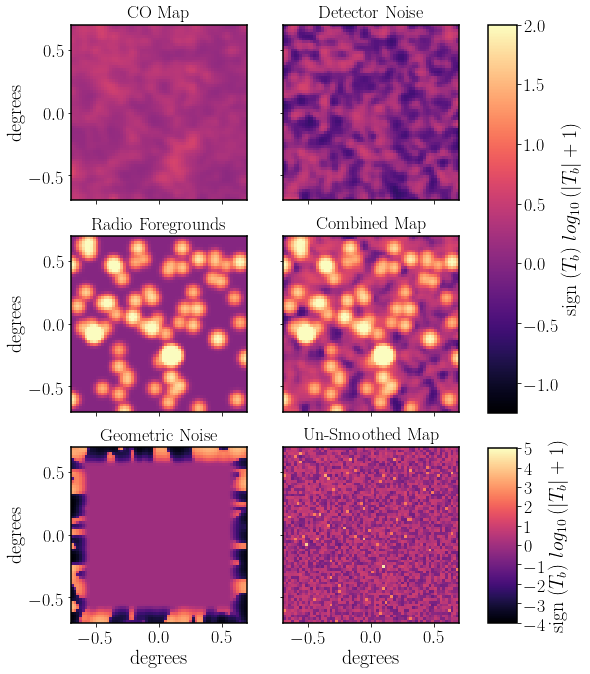

In [156]:
import matplotlib.colors as colors

fig, ax = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(8, 11))

cmap = 'magma'

im = ax[0,0].imshow(lnn.log_modulus(basic_pool_map_smoothed[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-1.25,vmax=2, cmap=cmap)

im = ax[0,1].imshow(lnn.log_modulus(noisy_pool_map_smoothed[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-1.25,vmax=2, cmap=cmap)

im = ax[1,0].imshow(lnn.log_modulus(foreground_pool_map_smoothed[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-1.25,vmax=2, cmap=cmap)

im = ax[1,1].imshow(lnn.log_modulus(combined_pool_map_smoothed[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-1.25,vmax=2, cmap=cmap)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.39, 0.05, 0.49])
fig.colorbar(im, cax=cbar_ax, label=r'\rm{sign} $\left(T_b \right)$ $log_{10}\left( |T_b| + 1 \right)$')

im = ax[2,0].imshow(lnn.log_modulus(geometric_pool_noise_map_smoothed[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-4.0,vmax=5, cmap=cmap)

im = ax[2,1].imshow(lnn.log_modulus(combined_map[:,:,0]), 
                extent=[-data['fov_x']/2,data['fov_x']/2,-data['fov_y']/2,data['fov_y']/2],
                vmin=-4.0,vmax=5, cmap=cmap)

fig.subplots_adjust(right=0.8)
cbar_ax2 = fig.add_axes([0.85, 0.125, 0.05, 0.22])
fig.colorbar(im, cax=cbar_ax2, label=r'\rm{sign} $\left(T_b \right)$ $log_{10}\left( |T_b| + 1 \right)$')

ax[0,0].set_title('CO Map', fontsize=18)
ax[0,1].set_title('Detector Noise', fontsize=18)
ax[1,0].set_title('Radio Foregrounds', fontsize=18)
ax[1,1].set_title('Combined Map', fontsize=18)
ax[2,0].set_title('Geometric Noise', fontsize=18)
ax[2,1].set_title('Un-Smoothed Map', fontsize=18)

ax[0,0].set_adjustable('box-forced')
ax[0,1].set_adjustable('box-forced')
ax[1,0].set_adjustable('box-forced')
ax[1,1].set_adjustable('box-forced')
ax[2,0].set_adjustable('box-forced')
ax[2,1].set_adjustable('box-forced')

ax[0,0].set_ylabel('degrees')
ax[1,0].set_ylabel('degrees')
ax[2,0].set_ylabel('degrees')

ax[2,0].set_xlabel('degrees')
ax[2,1].set_xlabel('degrees')

# plt.show()
plt.savefig('../figures/IM_slices.pdf', bbox_inches='tight')

# Not a figure, but needed for a table

## Figure out how accurate the scenarios are at different L

In [130]:
pred_dict = {}
pred_dict['No Noise Base Li'] = nnnmlf_pred['basic_basic_Li']
pred_dict['White Noise Base Li'] = nnnmlf_pred['noisy_basic_Li']
pred_dict['Random White Noise and Foregrounds Base Li'] = nnnmlf_pred['noisy_foreground_random_basic_Li']

pred_dict['No Noise Li'] = nnnmlf_pred['basic']
pred_dict['White Noise Li'] = nnnmlf_pred['noisy']
pred_dict['Random White Noise and Foregrounds Li'] = nnnmlf_pred['noisy_foreground_random']

pred_dict['Padmanabhan'] = nnnmlf_pred['basic_Padmanabhan']
pred_dict['Geometric Noise'] = nnnmlf_pred['geometric_noise']
pred_dict['Less Bright Sources'] = nnnmlf_pred['less_high_sources']

scenarios = ['No Noise Base Li', 'White Noise Base Li', 'Random White Noise and Foregrounds Base Li',
            'No Noise Li', 'White Noise Li', 'Random White Noise and Foregrounds Li',
            'Padmanabhan', 'Geometric Noise', 'Less Bright Sources',
            'Ihle et al.']

In [131]:
accuracies = {}
lumSpots = [6,20,34]

fiducial_pred = nnnmlf_pred['noisy_basic_Li']
conf_interval = np.array([fiducial_pred.transformed_res_conf_interval[:,0], fiducial_pred.transformed_res_conf_interval[:,1]])

fid_acc = []
fid_acc2 = []
for spot in lumSpots:
    fid_acc.append(conf_interval[1,spot])
    fid_acc2.append(conf_interval[0,spot])
fid_acc = fid_acc[0] #np.array(fid_acc)
fid_acc2 = fid_acc2[0] #np.array(fid_acc2)

for key, value in pred_dict.items():
    conf_interval = np.array([value.transformed_res_conf_interval[:,0], value.transformed_res_conf_interval[:,1]])
    
    acc = []
    acc2 = []
    for spot in lumSpots:
        acc.append(conf_interval[1,spot])
        acc2.append(conf_interval[0,spot])

    acc = np.array(acc)
    compare_acc = acc/fid_acc
    acc2 = np.array(acc2)
    compare_acc2 = acc2/fid_acc2
    accuracies[key] = np.array([acc, compare_acc, acc2, compare_acc2])
    
acc = []
acc2 = []
for spot in [4, 20, 36]:
    acc.append(2*upper_err[spot]/simulated_phi[spot])
    acc2.append(-2*lower_err[spot]/simulated_phi[spot])
    
acc = np.array(acc)
compare_acc = acc/fid_acc
acc2 = np.array(acc2)
compare_acc2 = acc2/fid_acc2
accuracies['Ihle et al.'] = np.array([acc, compare_acc, acc2, compare_acc2])

In [132]:
for scenario in scenarios:
    print(scenario, accuracies[scenario][0], accuracies[scenario][1])
    print("{0:1.2} & {1:1.2} & {2:1.2}".format((accuracies[scenario][1][0] + accuracies[scenario][3][0])/2, 
         (accuracies[scenario][1][1] + accuracies[scenario][3][1])/2, 
         (accuracies[scenario][1][2] + accuracies[scenario][3][2])/2))
    print()

No Noise Base Li [-0.06712769  0.31484424 -0.17507081] [-0.30849832  1.44692772 -0.80457181]
1.4 & 0.54 & 3.2

White Noise Base Li [ 0.21759501  0.3541151  -0.01368331] [ 1.          1.62740454 -0.06288431]
1.0 & 1.1 & 4.0

Random White Noise and Foregrounds Base Li [-0.01392278  0.01431659  0.01818873] [-0.06398483  0.06579466  0.08358983]
3.3 & 3.7 & 5.6

No Noise Li [ 0.16979428  0.69235178  2.11649451] [ 0.78032252  3.18183671  9.72676055]
2.6 & 2.7 & 9.3

White Noise Li [ 0.78641579  0.7946986   5.50011122] [  3.61412613   3.65219135  25.27682661]
2.3 & 2.2 & 1.7e+01

Random White Noise and Foregrounds Li [  0.70094613   0.47005362  11.60250063] [  3.22133373   2.16022246  53.32153936]
4.8 & 4.7 & 3.2e+01

Padmanabhan [ 0.20604031  0.35773255  0.21265857] [ 0.94689816  1.64402922  0.97731367]
2.8 & 2.8 & 4.3

Geometric Noise [  2.2112       2.46988257  49.41965144] [  10.16199798   11.35082383  227.11758209]
7.6 & 1.1e+01 & 1.2e+02

Less Bright Sources [ 0.62984092  0.41872748  9.